In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import joblib
import re
import os


In [39]:
# Load the data
df = pd.read_csv(r'C:/Users/honey/Documents/placment work/Electronical-AI-Device-Recogniser/khanya/data managment/datasets/acs-f2-dataset.csv')

# Data Preprocessing
# Drop the 'time' column as it's not relevant for prediction
df = df.drop('time', axis=1)

# Convert categorical labels to numeric
le = LabelEncoder()
df['equipment'] = le.fit_transform(df['equipment'])

# Split features and labels
X = df.drop('equipment', axis=1)
y = df['equipment']


In [40]:
#Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

# One-hot encode the target labels
num_classes = len(np.unique(y))
y_resampled_onehot = to_categorical(y_resampled, num_classes=num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_onehot, test_size=0.3, random_state=42)

In [41]:
# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.004),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.3, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

Epoch 1/200


c:\Users\honey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2224/2224 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.3902 - loss: 1.7482 - val_accuracy: 0.5878 - val_loss: 1.1509
Epoch 2/200
2224/2224 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5484 - loss: 1.2464 - val_accuracy: 0.6186 - val_loss: 1.0302
Epoch 3/200
2224/2224 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5925 - loss: 1.1207 - val_accuracy: 0.6599 - val_loss: 0.9419
Epoch 4/200
2224/2224 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6078 - loss: 1.0829 - val_accuracy: 0.6758 - val_loss: 0.9137
Epoch 5/200
2224/2224 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6241 - loss: 1.0294 - val_accuracy: 0.6819 - val_loss: 0.8858
Epoch 6/200
2224/2224 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6375 - loss: 1.0056 - val_accuracy: 0.6867 - val_loss: 0.8714
Epoch 7/200
2224/2224 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6366 - loss: 0.9951 - val_accuracy: 0.6966 - val_loss: 0.8423
Epoch 8/200
2224/2224 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6491 - loss: 0.9739 - val_

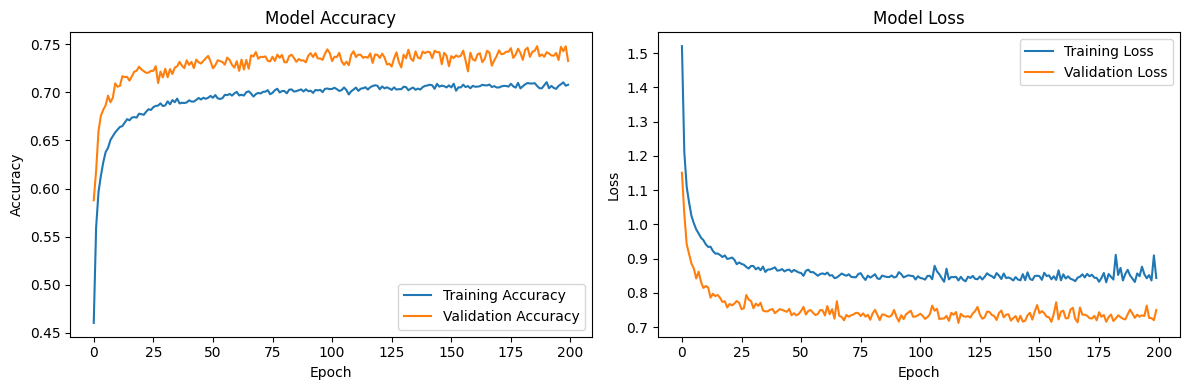

In [42]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


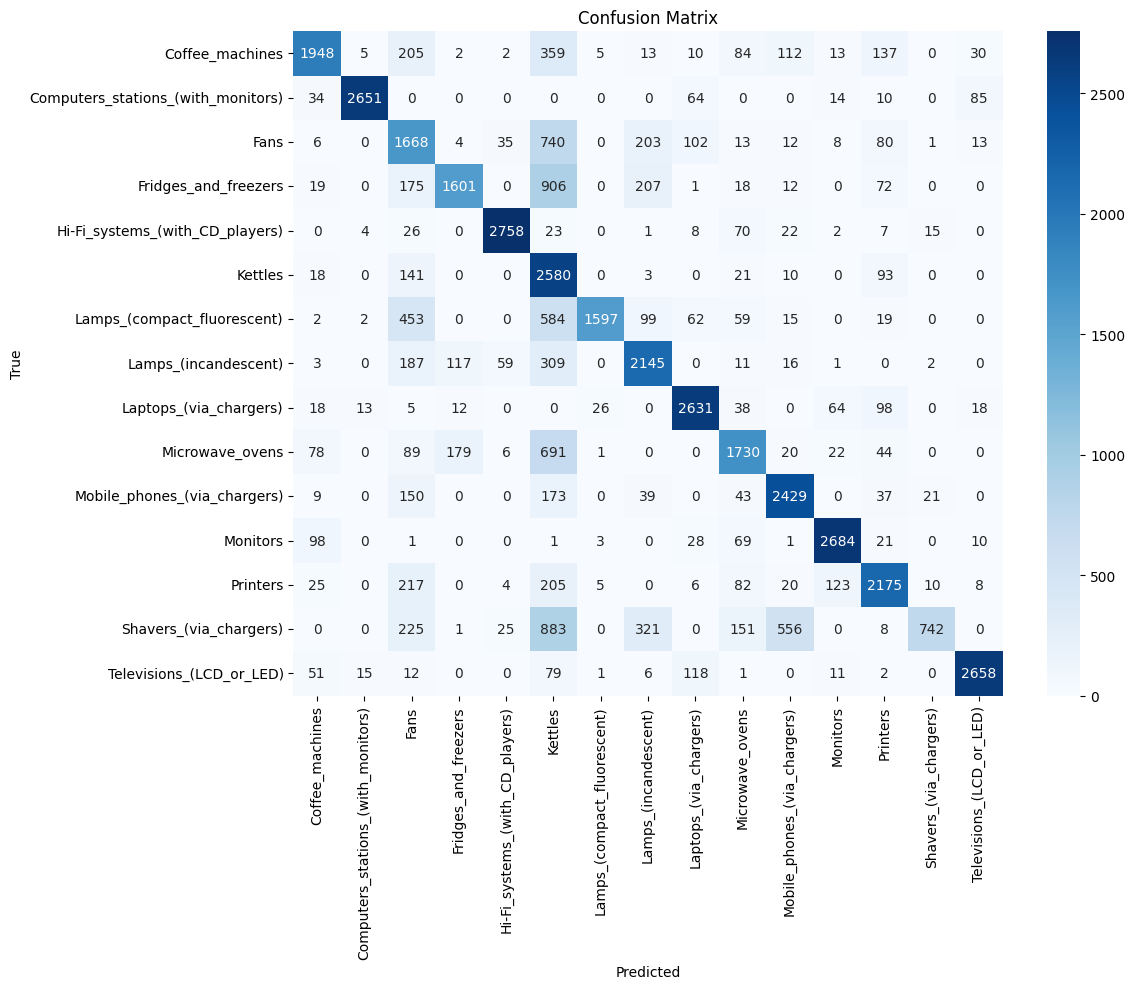

In [43]:
# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [44]:
# Function to predict appliance and probabilities
def predict_appliance(electrical_readings):
    # Ensure the input is a 2D array
    if electrical_readings.ndim == 1:
        electrical_readings = electrical_readings.reshape(1, -1)
    
    # Scale the input
    scaled_input = scaler.transform(electrical_readings)
    
    # Make prediction
    probabilities = model.predict(scaled_input)[0]
    predicted_class = le.inverse_transform([np.argmax(probabilities)])[0]
    
    return predicted_class, probabilities

# Example usage
example_reading = np.array([50.0, 340, 111.284, -40.89, 0.533, 224.038])
predicted_appliance, probabilities = predict_appliance(example_reading)

print(f"Predicted appliance: {predicted_appliance}")
print("Probabilities for each appliance:")
for appliance, prob in zip(le.classes_, probabilities):
    print(f"{appliance}: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted appliance: Televisions_(LCD_or_LED)
Probabilities for each appliance:
Coffee_machines: 0.0000
Computers_stations_(with_monitors): 0.0000
Fans: 0.0000
Fridges_and_freezers: 0.0000
Hi-Fi_systems_(with_CD_players): 0.0000
Kettles: 0.0000
Lamps_(compact_fluorescent): 0.0000
Lamps_(incandescent): 0.0000
Laptops_(via_chargers): 0.0000
Microwave_ovens: 0.0000
Mobile_phones_(via_chargers): 0.0000
Monitors: 0.0000
Printers: 0.0000
Shavers_(via_chargers): 0.0000
Televisions_(LCD_or_LED): 1.0000


c:\Users\honey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


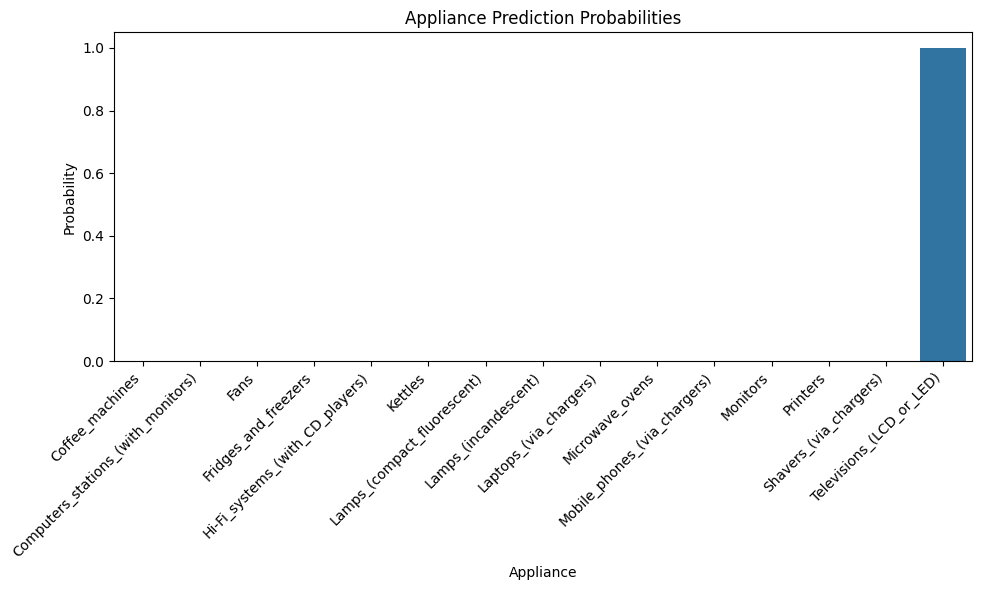

In [45]:
# Plot probabilities
plt.figure(figsize=(10, 6))
sns.barplot(x=le.classes_, y=probabilities)
plt.title('Appliance Prediction Probabilities')
plt.xlabel('Appliance')
plt.ylabel('Probability')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [46]:
# List and find versions of Keras model files in the directory
directory_path = 'C:/Users/honey/Documents/placment work/Electronical-AI-Device-Recogniser/khanya/juyniper notbooks'  # Define the directory path

pattern = re.compile(r'appliance_recogniser#(\d+\.\d+\.\d+)\.keras')
found_files = []
for file_name in os.listdir(directory_path):
    match = pattern.match(file_name)
    if match:
        version = match.group(1)
        found_files.append((file_name, version))

if found_files:
    for file_name, version in found_files:
        print(f"Found file: {file_name} with version: {version}")
else:
    print("No Keras files found in the directory.")

def get_next_version(file_name):
    # Find version pattern like 1.1.2
    match = re.search(r'(\d+\.\d+\.\d+)', file_name)
    if match:
        version_str = match.group(1)
        version_parts = list(map(int, version_str.split('.')))
        version_parts[-1] += 1  # Increment the last number
        next_version = '.'.join(map(str, version_parts))
        return file_name.replace(version_str, next_version)
    else:
        raise ValueError("No version found in file name")

# Example for scaler
scaler_file = 'scaler1.1.2.pkl'
next_scaler_file = get_next_version(scaler_file)
joblib.dump(scaler, next_scaler_file)
print(f"Saved scaler as: {next_scaler_file}")

# Example for model
model_file = 'appliance_recogniser#1.1.2.keras'
next_model_file = get_next_version(model_file)
model.save(next_model_file)
print(f"Saved model as: {next_model_file}")

Found file: appliance_recogniser#1.1.2.keras with version: 1.1.2
Found file: appliance_recogniser#1.1.3.keras with version: 1.1.3
Saved scaler as: scaler1.1.3.pkl
Saved model as: appliance_recogniser#1.1.3.keras


In [47]:
# Example for model
model_file = ' appliance_recogniser#1.1.'
next_model_file = get_next_version(model_file)
model.save(next_model_file)
print(f"Saved model as: {next_model_file}")

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare for storing metrics
all_confusion_matrices = []
all_classification_reports = []

# Cross-validation loop
for train_index, test_index in kf.split(X_resampled):
    # Split the data
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    
    # One-hot encode the labels
    y_train_onehot = to_categorical(y_train, num_classes=num_classes)
    y_test_onehot = to_categorical(y_test, num_classes=num_classes)
    
    # Build and compile the model
    model = Sequential([
        Dense(128, activation='relu', input_dim=X_train.shape[1]),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train_onehot, epochs=50, verbose=0)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Store confusion matrix and classification report for this fold
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    all_confusion_matrices.append(conf_matrix)

    class_report = classification_report(y_test, y_pred_classes, output_dict=True)
    all_classification_reports.append(class_report)


Saved model as: appliance_recogniser#1.1.3.keras


c:\Users\honey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step


c:\Users\honey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


c:\Users\honey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:

# # Ensure all_confusion_matrices is a list of numpy arrays
# all_confusion_matrices = [np.array(cm) for cm in all_confusion_matrices if isinstance(cm, np.ndarray)]

# # Filter out any non-array elements
# all_confusion_matrices = [cm for cm in all_confusion_matrices if isinstance(cm, np.ndarray)]

# # Ensure the list is not empty before calculating the mean
# if all_confusion_matrices:
#     average_conf_matrix = np.mean(all_confusion_matrices, axis=0)
#     average_classification_report = {key: np.mean([report[key]['f1-score'] for report in all_classification_reports])
#                                      for key in all_classification_reports[0].keys()}

#     print('Average Confusion Matrix:')
#     print(average_conf_matrix)

#     print('Average Classification Report (F1-Scores):')
# else:
#     print('No valid confusion matrices to average.')
# for key, score in average_classification_report.items():
#     print(f'{key}: {score}')
